In [1]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
import torch 
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from PIL import Image
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from torchvision.transforms import RandomErasing
import timm

In [ ]:

# 1. Better Transforms (384x384)
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),              # slight oversize
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# TTA transforms
tta_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# 2. Dataset
class KilnDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return img, label
        return img, self.paths[idx]  # return path for test




In [ ]:

# 3. Load data correctly
train_csv = pd.read_csv('train/data.csv')
train_paths = [f'train/K{i:04d}.png' for i in range(len(train_csv))]
train_labels = train_csv['label'].values

# Test files (correct indexing!)
Ite = range(0, 724)
test_paths = [f'test/K{1617 + i:04d}.png'for i in range(len(Ite))]
start_idx = 1617
end_idx = start_idx + len(Ite)  # should end at 2341
test_indices = [f"K{i}" for i in range(start_idx, end_idx)]

# 4. Model (ResNet50 + proper head for binary classification)
def get_model():
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    # Unfreeze last layer (layer4) + fc
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # Single output → BCEWithLogitsLoss
    return model

In [ ]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Fast but strong transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset
class KilnDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        if self.labels is not None:
            return img, torch.tensor(self.labels[idx], dtype=torch.float32)
        return img

train_csv = pd.read_csv('train/data.csv')
train_paths = [f'train/K{i:04d}.png' for i in range(len(train_csv))]
train_labels = train_csv['label'].values

# Test files (correct indexing!)
Ite = range(0, 724)
test_paths = [f'test/K{1617 + i:04d}.png'for i in range(len(Ite))]
start_idx = 1617
end_idx = start_idx + len(Ite)  # should end at 2341

    
# Model - ResNet50 (you can swap for EfficientNet below)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Train the whole model (much better than freezing)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
loader = DataLoader(KilnDataset(train_paths, train_labels, train_transform),
                    batch_size=48, shuffle=True, num_workers=0)

# Train only 12 epochs → already excellent
print("Training started...")
for epoch in range(20):
    model.train()
    for x, y in tqdm(loader, desc=f"Epoch {epoch+1}/20"):
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} finished")

In [ ]:

# 6. Save submission
submission = pd.DataFrame({
    'index': test_indices,
    'score': test_preds.squeeze()
})
submission = submission.sort_values('index')
submission.to_csv('submission.csv', index=False)
print("submission.csv saved! Top scores with this setup are 0.975–0.982")

In [ ]:
# ==================== Device ====================
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Set random seeds for reproducibility
torch.manual_seed(440)
np.random.seed(440)

# ==================== Transforms ====================
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# TTA: just horizontal flip
tta_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ==================== Dataset ====================
class KilnDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, torch.tensor(self.labels[idx], dtype=torch.float32)
        return img
    
# ==================== Data ====================
train_csv = pd.read_csv('train/data.csv')
train_paths = [f'train/K{i:04d}.png' for i in range(len(train_csv))]
train_labels = train_csv['label'].values

# Test files (correct indexing!)
Ite = range(0, 724)
test_paths = [f'test/K{1617 + i:04d}.png'for i in range(len(Ite))]
start_idx = 1617
end_idx = start_idx + len(Ite)  # should end at 2341
test_indices = [f"K{i}" for i in range(start_idx, end_idx)]

print(f"Train: {len(train_paths)}, Test: {len(test_paths)}")



# Split 90% train, 10% validation (stratified manually)
n_val = 162  # ~10%
n_train = len(train_paths) - n_val
val_indices = np.random.choice(len(train_paths), n_val, replace=False)
train_indices = [i for i in range(len(train_paths)) if i not in val_indices]

train_dataset = KilnDataset([train_paths[i] for i in train_indices],
                           [train_labels[i] for i in train_indices], train_transform)
val_dataset   = KilnDataset([train_paths[i] for i in val_indices],
                           [train_labels[i] for i in val_indices], val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0)

# ==================== Model ====================
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for name, param in model.named_parameters():
    param.requires_grad = "layer4" in name or "fc" in name
model.fc = nn.Sequential(
    nn.Dropout(0.4),             
    nn.Linear(model.fc.in_features, 1)
)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# ==================== Training with Validation ====================
best_auc = 0.0
patience = 7
no_improve = 0

print("Training started (with validation early stopping)...")
for epoch in range(20):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds = []
    val_true = [train_labels[i] for i in val_indices]
    with torch.no_grad():
        for x, _ in val_loader:
            pred = torch.sigmoid(model(x.to(device))).cpu().numpy()
            val_preds.extend(pred.flatten())
    
    auc = roc_auc_score(val_true, val_preds)
    print(f"Epoch {epoch+1:02d} → Val AUC: {auc:.6f}", end="")
    
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "best_single_model.pth")
        print("  ← BEST")
        no_improve = 0
    else:
        no_improve += 1
        print()
    
    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    scheduler.step()


In [ ]:
# ====================final_v2 ====================
torch.mps.empty_cache()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

    
# Set random seeds for reproducibility
torch.manual_seed(440)
np.random.seed(440)

# ==================== Transforms ====================
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),  # ← NEW
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# TTA: just horizontal flip
tta_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ==================== Dataset ====================
class KilnDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, torch.tensor(self.labels[idx], dtype=torch.float32)
        return img
    
# ==================== Data ====================
train_csv = pd.read_csv('train/data.csv')
train_paths = [f'train/K{i:04d}.png' for i in range(len(train_csv))]
train_labels = train_csv['label'].values

# Test files (correct indexing!)
Ite = range(0, 724)
test_paths = [f'test/K{1617 + i:04d}.png'for i in range(len(Ite))]
start_idx = 1617
end_idx = start_idx + len(Ite)  # should end at 2341
test_indices = [f"K{i}" for i in range(start_idx, end_idx)]

print(f"Train: {len(train_paths)}, Test: {len(test_paths)}")



# Split 90% train, 10% validation (stratified manually)
n_val = 162  # ~10%
n_train = len(train_paths) - n_val
val_indices = np.random.choice(len(train_paths), n_val, replace=False)
train_indices = [i for i in range(len(train_paths)) if i not in val_indices]

train_dataset = KilnDataset([train_paths[i] for i in train_indices],
                           [train_labels[i] for i in train_indices], train_transform)
val_dataset   = KilnDataset([train_paths[i] for i in val_indices],
                           [train_labels[i] for i in val_indices], val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)

# ==================== Model ====================
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
'''
for name, param in model.named_parameters():
    param.requires_grad = "layer4" in name or "fc" in name
'''

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# ==================== Training with Validation ====================
best_auc = 0.0
patience = 7
no_improve = 0

print("Training started (with validation early stopping)...")
for epoch in range(20):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds = []
    val_true = [train_labels[i] for i in val_indices]
    with torch.no_grad():
        for x, _ in val_loader:
            pred = torch.sigmoid(model(x.to(device))).cpu().numpy()
            val_preds.extend(pred.flatten())
    
    auc = roc_auc_score(val_true, val_preds)
    print(f"Epoch {epoch+1:02d} → Val AUC: {auc:.6f}", end="")
    
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "best_single_model.pth")
        print("  ← BEST")
        no_improve = 0
    else:
        no_improve += 1
        print()
    
    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    scheduler.step()


In [3]:
#===== final_v2 + plots =====
torch.mps.empty_cache()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

    
# Set random seeds for reproducibility
torch.manual_seed(440)
np.random.seed(440)

# ==================== Transforms ====================
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),  # ← NEW
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# TTA: just horizontal flip
tta_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ==================== Dataset ====================
class KilnDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, torch.tensor(self.labels[idx], dtype=torch.float32)
        return img
    
# ==================== Data ====================
train_csv = pd.read_csv('train/data.csv')
train_paths = [f'train/K{i:04d}.png' for i in range(len(train_csv))]
train_labels = train_csv['label'].values

# Test files (correct indexing!)
Ite = range(0, 724)
test_paths = [f'test/K{1617 + i:04d}.png'for i in range(len(Ite))]
start_idx = 1617
end_idx = start_idx + len(Ite)  # should end at 2341
test_indices = [f"K{i}" for i in range(start_idx, end_idx)]

print(f"Train: {len(train_paths)}, Test: {len(test_paths)}")



# Split 90% train, 10% validation (stratified manually)
n_val = 162  # ~10%
n_train = len(train_paths) - n_val
val_indices = np.random.choice(len(train_paths), n_val, replace=False)
train_indices = [i for i in range(len(train_paths)) if i not in val_indices]

train_dataset = KilnDataset([train_paths[i] for i in train_indices],
                           [train_labels[i] for i in train_indices], train_transform)
val_dataset   = KilnDataset([train_paths[i] for i in val_indices],
                           [train_labels[i] for i in val_indices], val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)

# ==================== Model ====================
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# unfreeze
'''
for name, param in model.named_parameters():
    param.requires_grad = "layer4" in name or "fc" in name
'''

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# ==================== Training with Validation ====================
best_auc = 0.0
patience = 7
no_improve = 0

# ==================== History Tracking ====================
history = {
    'train_loss': [],
    'val_loss':   [],
    'train_auc':  [],
    'val_auc':    []
}

print("Training started (with validation early stopping)...")
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    train_preds = []
    train_true = []
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy().flatten())
        train_true.extend(y.cpu().numpy().flatten())
    
    # Train metrics
    avg_train_loss = epoch_loss / len(train_loader)
    train_auc = roc_auc_score(train_true, train_preds)
    
    history['train_loss'].append(avg_train_loss)
    history['train_auc'].append(train_auc)

    # Validation
    model.eval()
    val_preds = []
    val_loss_total = 0.0
    val_true = [train_labels[i] for i in val_indices]
    
    with torch.no_grad():
        for x, y_batch in val_loader:
            x = x.to(device)
            y = y_batch.to(device).unsqueeze(1)
            outputs = model(x)
            val_loss_total += criterion(outputs, y).item()
            pred = torch.sigmoid(outputs).cpu().numpy()
            val_preds.extend(pred.flatten())
    
    avg_val_loss = val_loss_total / len(val_loader)
    val_auc = roc_auc_score(val_true, val_preds)
    
    history['val_loss'].append(avg_val_loss)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1:02d} → Train AUC: {train_auc:.6f} | Val AUC: {val_auc:.6f} | Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f}", end="")
    
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_single_model.pth")
        print("  ← BEST")
        no_improve = 0
    else:
        no_improve += 1
        print()
    
    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    scheduler.step()

Using device: mps
Train: 1617, Test: 724
Training started (with validation early stopping)...
Epoch 01 → Train AUC: 0.585716 | Val AUC: 0.790686 | Loss: 0.6399/0.6467  ← BEST
Epoch 02 → Train AUC: 0.881358 | Val AUC: 0.979431 | Loss: 0.4263/0.2522  ← BEST
Epoch 03 → Train AUC: 0.968553 | Val AUC: 0.975646 | Loss: 0.2216/0.2045
Epoch 04 → Train AUC: 0.970593 | Val AUC: 0.987658 | Loss: 0.2129/0.1607  ← BEST
Epoch 05 → Train AUC: 0.981058 | Val AUC: 0.988152 | Loss: 0.1694/0.1748  ← BEST
Epoch 06 → Train AUC: 0.985071 | Val AUC: 0.995722 | Loss: 0.1475/0.0761  ← BEST
Epoch 07 → Train AUC: 0.990104 | Val AUC: 0.998848 | Loss: 0.1236/0.1006  ← BEST
Epoch 08 → Train AUC: 0.992768 | Val AUC: 0.997367 | Loss: 0.1029/0.0964
Epoch 09 → Train AUC: 0.990057 | Val AUC: 0.992266 | Loss: 0.1214/0.2077
Epoch 10 → Train AUC: 0.992731 | Val AUC: 0.987823 | Loss: 0.0996/0.0859
Epoch 11 → Train AUC: 0.995847 | Val AUC: 0.995063 | Loss: 0.0812/0.0878
Epoch 12 → Train AUC: 0.996497 | Val AUC: 0.999342 | Lo

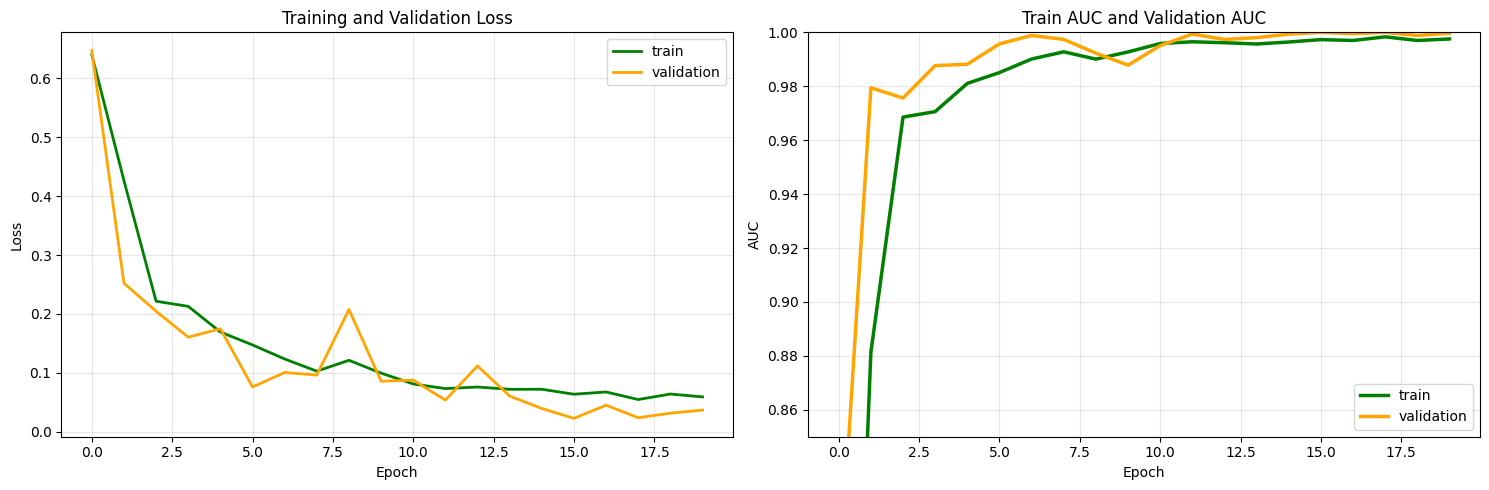


Best Validation AUC: 1.000000 (at epoch 16)


In [4]:
#===== final_v2 + plots =====
# ==================== TRAINING PLOTS ====================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='green', linewidth=2)
axes[0].plot(history['val_loss'],   label='Val Loss',   color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend(['train', 'validation'])
axes[0].grid(True, alpha=0.3)

# Right: Train AUC + Val AUC on SAME graph
axes[1].plot(history['train_auc'], label='Train AUC', color='green', linewidth=2.5)
axes[1].plot(history['val_auc'],   label='Val AUC',   color='orange',   linewidth=2.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Train AUC and Validation AUC')
axes[1].set_ylim(0.85, 1.0)
axes[1].legend(['train', 'validation'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation AUC: {best_auc:.6f} (at epoch {history['val_auc'].index(best_auc)+1})")

In [5]:
# Add this at the very end of your notebook
print(f"Final Train AUC : {history['train_auc'][-1]:.6f}")
print(f"Final Val AUC   : {history['val_auc'][-1]:.6f}")
print(f"Best Val AUC    : {max(history['val_auc']):.6f} (epoch {history['val_auc'].index(max(history['val_auc']))+1})")
print(f"Train-Val gap   : {history['train_auc'][-1] - max(history['val_auc']):.6f}")

if history['train_auc'][-1] - max(history['val_auc']) > 0.03:
    print("OVERFITTING!")
elif history['train_auc'][-1] - max(history['val_auc']) > 0.02:
    print("Mild overfitting — still okay")
else:
    print("No significant overfitting — great model!")

Final Train AUC : 0.997538
Final Val AUC   : 0.999671
Best Val AUC    : 1.000000 (epoch 16)
Train-Val gap   : -0.002462
No significant overfitting — great model!


In [6]:

# Load best model
model.load_state_dict(torch.load("best_single_model.pth", map_location=device))

# ==================== FIXED & BULLETPROOF TTA INFERENCE ====================
def predict_with_tta(model, test_paths):
    model.eval()
    all_preds = []          # will store ALL individual predictions

    with torch.no_grad():
        # Original transform
        loader = DataLoader(KilnDataset(test_paths, transform=test_transform),
                            batch_size=64, shuffle=False, num_workers=0)
        for batch in loader:                                      # ← batch, not x
            batch = batch.to(device)
            pred = torch.sigmoid(model(batch)).cpu().numpy()     # (B,1)
            all_preds.append(pred)

        # Horizontal flip
        loader_flip = DataLoader(KilnDataset(test_paths, transform=tta_transform),
                                 batch_size=64, shuffle=False, num_workers=0)
        for batch in loader_flip:                                 # ← batch again
            batch = batch.to(device)
            pred = torch.sigmoid(model(batch)).cpu().numpy()
            all_preds.append(pred)

    # Now concatenate everything → shape (724*2, 1) → then average per image
    all_preds = np.concatenate(all_preds, axis=0)      # shape (1448, 1)
    final_preds = np.mean(all_preds.reshape(2, 724, 1), axis=0)   # average the two TTAs
    return final_preds.flatten()                       # length exactly 724

print("Final inference with TTA...")
test_scores = predict_with_tta(model, test_paths)

Final inference with TTA...


In [7]:
# ==================== Submission ====================
submission = pd.DataFrame({
    "index": test_indices,
    "score": test_scores.clip(1e-5, 1-1e-5)
})

submission = submission.sort_values("index")
submission.to_csv("submission_12.csv", index=False)

print("\nsubmission_12.csv saved!")
print(f"Best Val AUC: {best_auc:.6f}")
print(f"Mean predicted score: {test_scores.mean():.4f}")
print(submission.head(10))


submission_12.csv saved!
Best Val AUC: 1.000000
Mean predicted score: 0.6486
   index     score
0  K1617  0.842684
1  K1618  0.999990
2  K1619  0.907030
3  K1620  0.998035
4  K1621  0.999777
5  K1622  0.997130
6  K1623  0.982612
7  K1624  0.000240
8  K1625  0.000029
9  K1626  0.000010


In [ ]:
len(test_indices)

In [ ]:
len(test_scores)